Code for plots in the paper.

In [8]:
import matplotlib
# matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import argparse
import numpy as np
import seaborn as sns
import pickle
import pandas as pd
import os
from scipy.ndimage import gaussian_filter1d
import glob

## to get the latex format
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Computer Modern",
    "font.size" : 25,
    "font.weight" :900,
    "legend.fontsize" : 25,
    "xtick.labelsize" : 20,
    "ytick.labelsize" : 20,
    # 'axes.labelcolor': 'black',
    'axes.labelsize': 20,
    'axes.labelweight': 900,
    # "figure.dpi":300,
    # 'legend.fontsize': 20.0,
    # 'legend.labelcolor': 'black',
    'text.latex.preamble' :r'''
    \boldmath
    \usepackage{amsmath}
    \renewcommand{\rmdefault}{cmr}  % Use Computer Modern Roman
    '''
})


In [18]:
## path to the results from disease_metric_estimation results
curr_dir = os.getcwd()
folder_name = 'sir_feat'
gamma = 1 ## change it to recovery time (1/gamma) defined in the pipeline.sh
dup = 'True' ## variable to include or exclude duplicate sample points (put same as in pipeline.sh)

## Degree distribution comparison

### Step 1 : pre-processing the output from degree_distribution.py script

In [14]:
network = 'ER' ## change the name of network for other network types
file_ls = glob.glob(f"{curr_dir}/{folder_name}/{network}*_deg.pkl")
deg_dict = {'OG':[],'RW':[],'MHRW':[]}
for filepath in file_ls:
    tmp_deg_dict = pickle.load(open(filepath,"rb"))
    for key in deg_dict.keys():
        deg_dict[key].extend(tmp_deg_dict[key])

for i,algo in enumerate(['OG','RW','MHRW']):
    print(f"{algo} starts")
    degree_flat = deg_dict[algo]
    count = np.bincount(degree_flat)/len(degree_flat)
    y_smooth = gaussian_filter1d(count[1:], sigma=2)
    max_count = np.max(count)
    k = np.arange(1, max(degree_flat) + 1)
    tmp_dict = {'k':k,'y':y_smooth,'count':count[1:]}
    df = pd.DataFrame(tmp_dict)
    if i==0:
        master_df = df.copy()
    else :
        df.columns = [f"{col}_{algo}" for col in df.columns]
        master_df = pd.merge(master_df,df, left_on ='k', right_on=f'k_{algo}',how='left')
    print(f"{algo} ends")

master_df['net_RW'] = (master_df['count_RW'])/master_df['count']
master_df['net_MHRW'] = ( master_df['count_MHRW'])/master_df['count']
master_df = master_df.dropna()

OG starts
OG ends
RW starts
RW ends
MHRW starts
MHRW ends


### Step 2: Plotting the degree distribution 

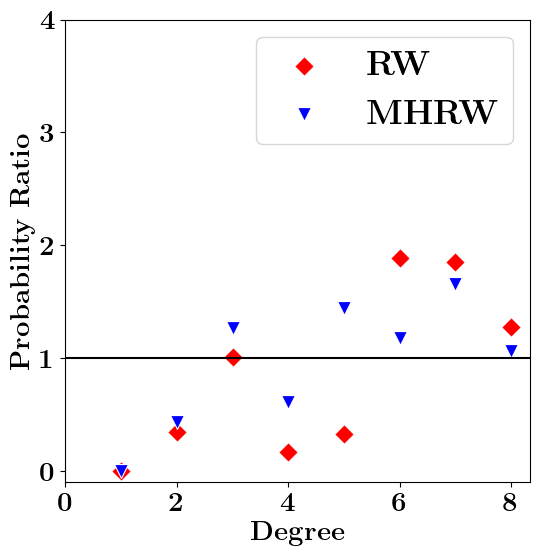

In [15]:
if network.find("SF")>=0:
    xll = 1000
    xul = 200
    yul = 50
else :
    xll = max(master_df['k'])
    xul = 2
    yul = 1

plt.figure(figsize=(6,6))

marker_map = {'RW':'D','MHRW':'v'}
color_map = {'RW':'red','MHRW':'blue'}
plot_df =  master_df[master_df['k']<=xll]

for algo in ['RW','MHRW']:

    sns.scatterplot(x=plot_df['k']
                    ,y=plot_df[f'net_{algo}']
                    ,label=r"$\textbf{"+algo+r"}$"
                    ,color=color_map[algo]
                    ,s=100
                    ,marker=marker_map[algo])
    
    if network.find("SF")>=0:
        plt.yticks(np.arange(0,250+yul,yul))
    else :
        plt.yticks(np.arange(0,max(plot_df['net_RW']+plot_df['net_MHRW'])+yul,yul))
    
    plt.xticks(np.arange(0,xll+xul,xul))

plt.axhline(y=1,color='black')
plt.legend()
plt.ylabel(r'\textbf{Probability Ratio}')
plt.xlabel(r'\textbf{Degree}')


## Plotting disease metric 

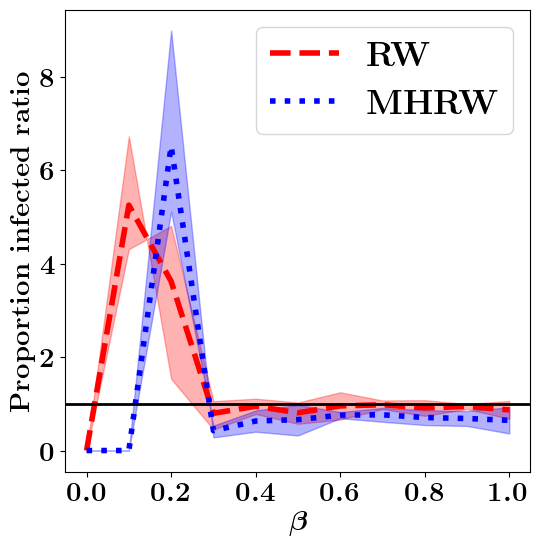

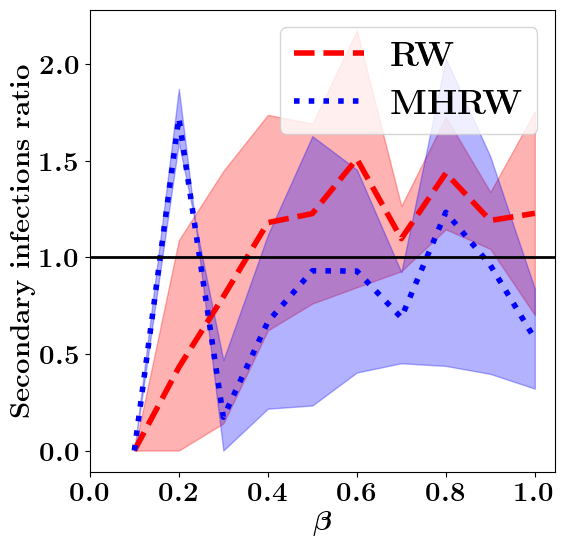

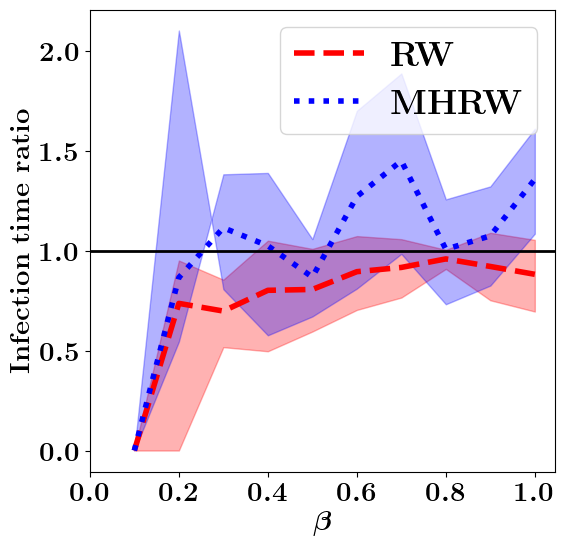

In [36]:
directory = 'sir_feat'
network = 'ER' ## change it for other networks
master_df = pd.DataFrame()
for algo in ['OG','RW','MHRW']:
    file_ls = glob.glob(f"{curr_dir}/{folder_name}/{network}*_{gamma}_{algo}.pkl")
    for filepath in file_ls:
        df = pickle.load(open(filepath,"rb"))
        if dup!='True': df['scaler'] = df['sample_size']
        else :
            if algo != 'OG' : df['scaler'] = 10 ## sample size
            else : df['scaler'] = 10000 ## network size 
        df['node_idx'] = df['node_idx']/df['scaler']
        master_df = pd.concat([master_df,df],axis=0)

custom_palette = {
    'OG': ['purple','o','-'], 
    'RW': ['red','v','--'], 
    'MHRW':['blue','s',':']
}
xlabeldict = {'node_idx': 'Proportion infected',
                'second_inf':'Secondary infections',
                'inf_time':'Infection time'}
for col in ['node_idx','second_inf','inf_time']:
    pivot_df = pd.pivot_table(master_df, 
                            values=col, 
                            index='beta', 
                            columns='algo', 
                            aggfunc=['mean','std'],  
                            fill_value=0)   # Fill missing values with 0

    pivot_df = pivot_df.reset_index()
    pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
    
    for algo in ['RW','MHRW']:
        pivot_df[f'{algo}_ratio'] = pivot_df[f'mean_{algo}']/ pivot_df['mean_OG']
        pivot_df[f'{algo}_ratio_max'] = (pivot_df[f'mean_{algo}']+pivot_df[f'std_{algo}'])/ (pivot_df['mean_OG']+pivot_df['std_OG'])
        pivot_df[f'{algo}_ratio_min'] = (pivot_df[f'mean_{algo}']-pivot_df[f'std_{algo}'])/ (pivot_df['mean_OG']-pivot_df['std_OG'])

        pivot_df[f'{algo}_ratio'] = pivot_df[f'{algo}_ratio'].apply(lambda x: 0 if x<0 else x)
        pivot_df[f'{algo}_ratio_max']  = pivot_df[f'{algo}_ratio_max'].apply(lambda x: 0 if x<0 else x)
        pivot_df[f'{algo}_ratio_min'] = pivot_df[f'{algo}_ratio_min'].apply(lambda x: 0 if x<0 else x)

    plt.figure(figsize=(6,6))
    for algo in ['RW','MHRW']:
        plt.plot(pivot_df['beta_'],pivot_df[f'{algo}_ratio'],label=r'\textbf{'+algo+'}',linewidth=4,linestyle=custom_palette[algo][2],color=custom_palette[algo][0])
        plt.fill_between(pivot_df['beta_'],
                        pivot_df[f'{algo}_ratio_min'],
                        pivot_df[f'{algo}_ratio_max'],
                        alpha=0.3,
                        color=custom_palette[algo][0]
                        )
        plt.xticks(np.arange(0,1.2,0.2))
    plt.axhline(y=1,color='black',linestyle='-',linewidth=2)
    plt.xlabel(r'\textbf{$\beta$}')
    plt.ylabel(r'\textbf{'+xlabeldict[col]+' ratio}')
    plt.legend()

